# ECE 795 - Big Data
## Homework_5_part2 - Twitter Word Count using PySpark Distributed Computing on DataProc (Due 3/31, 40 Total Points)

### Provide your credentials to the runtime

In [1]:
# Authenticate your student profile

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### Set the Project ID and Enable APIs

In [2]:
project_id = 'yz0405'

#### In GCP, there are many different services; Compute Engine, Cloud Storage, BigQuery, Cloud SQL, Cloud Dataproc to name a few. In order to use any of these services in your project, you first have to enable them.

![alt text](https://cdn-images-1.medium.com/max/1600/1*rYZZH8w9iScxIXG27qG-ww.png)

#### Put your mouse over “APIs & Services” on the left-side menu, then click into “Library”. For this project, we will enable three APIs: Cloud Dataproc, Compute Engine, and Cloud Storage.

![alt text](https://cdn-images-1.medium.com/max/1600/1*qH5u_JSH2JLZW_SQTcetSQ.png)

### Running Example 1: Word Count

#### This word count example will use the Shakespeare dataset in BigQuery. The only difference is that instead of using Hadoop, it uses PySpark which is a Python library for Spark

Step 1: create a dataset named "wordcount_dataset"
- Select your project or create a new one, remember to enable billing
- Go to Big Query
- Create a dataset, and name it wordcount_dataset

![alt text](https://github.com/msaadsadiq/BigDataCourse/blob/master/Assign3_img11.png?raw=true)

#### Step 2: create a cluster in Dataproc and Google Cloud Storage. Go to Dataproc and create a cluster similar to our previous tutorial. It should look like this

![alt text](https://github.com/msaadsadiq/BigDataCourse/blob/master/Assgn3_img2.png?raw=true)

Now click on the link in the “Cloud Storage staging bucket” column, it will bring you to your Cloud
Storage. This is where we will upload our python code, which will then give us a link to submit a job to the cluster.

#### Step 3: modify the code and upload it to Cloud Storage. Download the following code from here (Fill word count Spark code by yourself)

Change the input and output directory strings. Replace the {} symbols with your Cloud Storage Bucket id.

input_directory =
'gs://{}/hadoop/tmp/bigquery/pyspark_input'.
output_directory =

'gs://{}/hadoop/tmp/bigquery/pyspark_output'

Upload the python file to your Cloud Storage. We will use this link as input to our PySpark job.

In [ ]:
!pip install pyspark

![alt text](https://github.com/msaadsadiq/BigDataCourse/blob/master/Assgn3_img3.png?raw=true)

For example, here I uploaded sparkwc.py, and my link would be gs://dataproc-e4225d08-23a8-481faff9-5205024119a5-us/sparkwc.py

#### Step 4: submit the job. Similar to our Hadoop example. Use the settings below. Remember to use your own gs:// link, not mine. 

![alt text](https://github.com/msaadsadiq/BigDataCourse/blob/master/Assgn3_img12.png?raw=true)

#### Step 5: browse the result. Once the job is done (should be around 2~10 minutes). Go back to Big Query and explore the result.

![alt text](https://github.com/msaadsadiq/BigDataCourse/blob/master/Assgn3_img5.png?raw=true)

 #### Reference. 
https://cloud.google.com/dataproc/docs/tutorials/bigquery-connector-spark-example
https://piazza.com/class_profile/get_resource/j1318wb5md21wb/j2jthscnpkb5zu

### Question 1. 

1. Download 10,000 Tweets about any topic you like (english language) from https://data.world/datasets/twitter
2. Save them as csv and Upload Tweets to storage bucket
3. Using PySpark to import those tweets to rdd or dataframe.

### Question 2. 

1. Perform a total word count on your tweets.
2. Perform a word count for each type of the words on your tweets.

In [ ]:
#!/usr/bin/python
"""BigQuery I/O PySpark example."""
from __future__ import absolute_import
import json
import pprint
import subprocess
import pyspark
from pyspark.sql import SQLContext

sc = pyspark.SparkContext()

# Use the Cloud Storage bucket for temporary BigQuery export data used
# by the InputFormat. This assumes the Cloud Storage connector for
# Hadoop is configured.
bucket = sc._jsc.hadoopConfiguration().get('fs.gs.system.bucket')
project = sc._jsc.hadoopConfiguration().get('fs.gs.project.id')
input_directory = 'gs://yz795/hadoop/tmp/bigquery/pyspark_input'.format(bucket)

conf = {
    # Input Parameters.
    'mapred.bq.project.id': project,
    'mapred.bq.gcs.bucket': bucket,
    'mapred.bq.temp.gcs.path': input_directory,
    'mapred.bq.input.project.id': 'yz0405',
    'mapred.bq.input.dataset.id': 'wordcount_dataset',
    'mapred.bq.input.table.id': 'elonmusk_tweets',
}

# Output Parameters.
output_dataset = 'wordcount_dataset'
output_table = 'wordcount_output'

# Load data in from BigQuery.
table_data = sc.newAPIHadoopRDD(
    'com.google.cloud.hadoop.io.bigquery.JsonTextBigQueryInputFormat',
    'org.apache.hadoop.io.LongWritable',
    'com.google.gson.JsonObject',
    conf=conf)

# Perform word count.

################################################################################
# Fill by yourself
################################################################################

# demo for publicdata
# word_counts = (
#     table_data
#     .map(lambda record: json.loads(record[1]))
#     .map(lambda x: (x['word'].lower(), int(x['word_count'])))
#     .reduceByKey(lambda x, y: x + y))

# for tw elonmusk_tweets dataset
words = table_data.map(lambda a: eval(eval(a[1])['text']).decode('utf-8')).flatMap(lambda a: a.split(' '))
word_counts = words.map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b).sortBy(lambda a: -a[1])

# Display 10 results.
pprint.pprint(word_counts.take(10))

# Stage data formatted as newline-delimited JSON in Cloud Storage.
output_directory = 'gs://yz795/hadoop/tmp/bigquery/pyspark_output'.format(bucket)
output_files = output_directory + '/part-*'

sql_context = SQLContext(sc)
(word_counts
 .toDF(['word', 'word_count'])
 .write.format('json').save(output_directory))

# Shell out to bq CLI to perform BigQuery import.
subprocess.check_call(
    'bq load --source_format NEWLINE_DELIMITED_JSON '
    '--replace '
    '--autodetect '
    '{dataset}.{table} {files}'.format(
        dataset=output_dataset, table=output_table, files=output_files
    ).split())

# Manually clean up the staging_directories, otherwise BigQuery
# files will remain indefinitely.
input_path = sc._jvm.org.apache.hadoop.fs.Path(input_directory)
input_path.getFileSystem(sc._jsc.hadoopConfiguration()).delete(input_path, True)
output_path = sc._jvm.org.apache.hadoop.fs.Path(output_directory)
output_path.getFileSystem(sc._jsc.hadoopConfiguration()).delete(
    output_path, True)

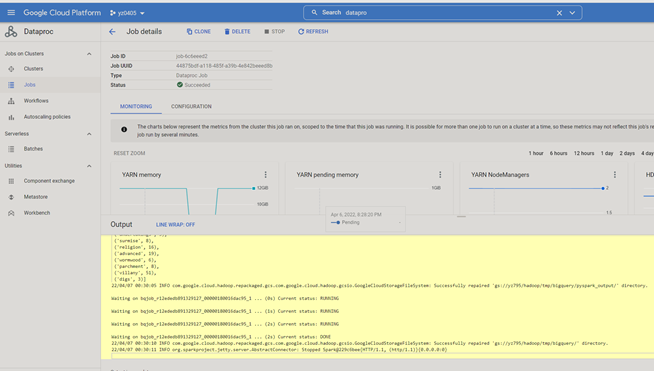

In [12]:
from IPython.display import Image, display
display(Image('/content/demo_succeeded.png', width=1000, height=600))

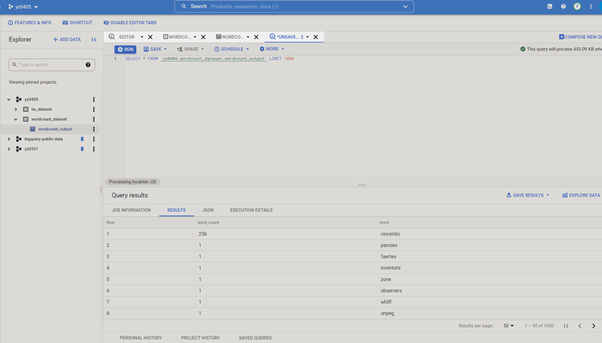

In [13]:
display(Image('/content/demo_result.png', width=1000, height=600))

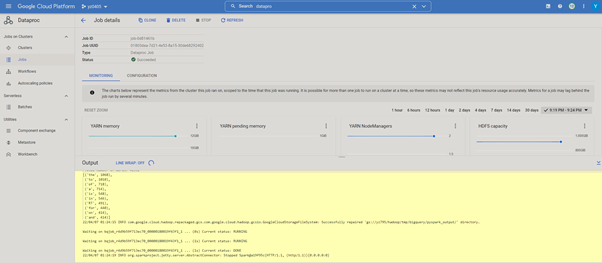

In [14]:
display(Image('/content/tweet_succeeded.png', width=1000, height=600))

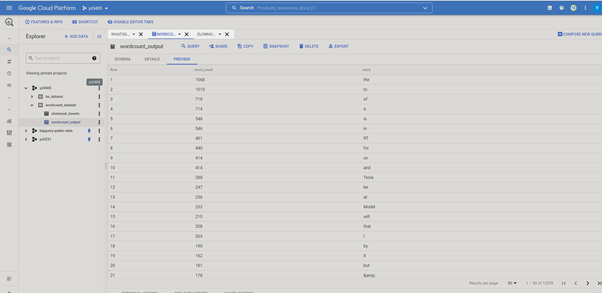

In [15]:
display(Image('/content/tweet_result.png', width=1000, height=600))